# Imports and parameters

In [1]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt
import copy

from minot.ClusterTools import map_tools
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
# Data
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'

# Map parameters
FWHM_planck = 10.0*u.arcmin
map_fov = 6*u.deg
map_reso = 2.5*u.arcmin
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))

# Analysis
Nmc = 500
reset_mcmc = True
mask_source = True
NFWHMmask = 3
src1 = SkyCoord("3h19m48.16s +41d30m42s", frame='icrs')              # NGC1275
src2 = SkyCoord(48.25948051*u.deg, +41.35073379*u.deg, frame='icrs') # as the peak of the map
yprof_reso = 5.0*u.arcmin

# Define the cluster model

In [10]:
cluster = minot.Cluster(name='Perseus', redshift=0.0179, M500=6.2e14*u.Msun, cosmology=FlatLambdaCDM(70,0.27,2.7), silent=True)
cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*0.73, 'n_01':3.9e-2*u.cm**-3*0.73**-0.5,
                             'beta2':0.58, 'r_c2':280*u.kpc*0.73, 'n_02':4.05e-3*u.cm**-3*0.73**-0.5}
cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*0.73, 'n_01':3.9e-2*u.cm**-3*0.73**-0.5,
                             'beta2':0.71, 'r_c2':13.18*u.arcmin*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift), 'n_02':2.8e-3*u.cm**-3*0.73**-0.5}

radius = np.logspace(0,5,1000)*u.kpc
T_e = 4.06*u.keV*((radius.to_value('kpc')/294)**6.72+0.72)/(1+(radius.to_value('kpc')/294)**6.72) * ((radius.to_value('Mpc')/1.6)**-0.33) / (1+(radius.to_value('Mpc')/1.6)**16.24)**(2.36/16.24)
radius, n_e = cluster.get_density_gas_profile(radius)
P_e = n_e*T_e
cluster.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}
cluster.R500 = 59.7*u.arcmin*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)
cluster.set_pressure_gas_gNFW_param('P13UPP')
#cluster.pressure_gas_model['c'] = 0.45

cluster.R_truncation = 5*cluster.R500
cluster.coord = SkyCoord("3h19m47.2s +41d30m47s", frame='icrs')
cluster.output_dir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'
cluster.map_fov = map_fov
cluster.map_reso = map_reso

(<Quantity [1303.1248757] kpc>, <Quantity [2.39257782e+63] erg>)


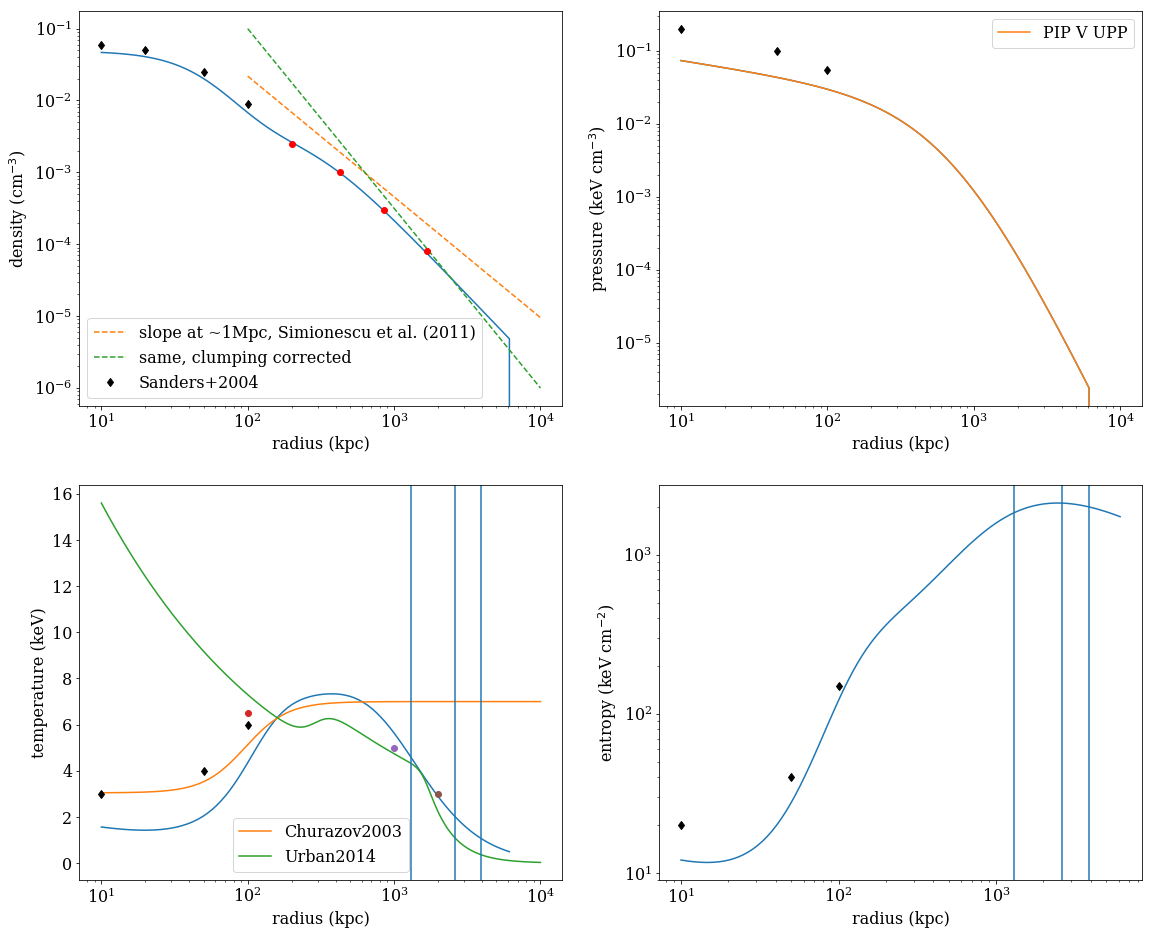

In [8]:
fig = plt.figure(0, figsize=(18, 16))
ax = plt.subplot(221)
r,n = cluster.get_density_gas_profile(np.logspace(1,4,100)*u.kpc)
plt.loglog(r,n)
r = np.logspace(2,4,100)*u.kpc
plt.loglog(r, 50*r**-1.68, linestyle='--', label='slope at ~1Mpc, Simionescu et al. (2011)')
plt.loglog(r, 10000*r**-2.50, linestyle='--', label='same, clumping corrected')
plt.loglog([430,850,200,77*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift).to_value('kpc arcmin-1')], [0.001,0.0003,0.0025,0.00008], marker='o', linestyle='', color='red')
plt.loglog([10,20,50,100], [0.06,0.05,0.025,0.009], marker='d', linestyle='', color='k', label='Sanders+2004')
plt.xlabel('radius (kpc)')
plt.ylabel('density (cm$^{-3}$)')
plt.legend()

ax = plt.subplot(222)
r,p = cluster.get_pressure_gas_profile(np.logspace(1,4,100)*u.kpc)
plt.loglog(r,p)
plt.loglog([10,45,100], [0.2,0.1,0.055], marker='d', linestyle='', color='k')
ctmp = copy.deepcopy(cluster)
ctmp.set_pressure_gas_gNFW_param('P13UPP')
r, p_r = ctmp.get_pressure_gas_profile(np.logspace(1,4,100)*u.kpc)
plt.loglog(r, p_r, label='PIP V UPP')
plt.xlabel('radius (kpc)')
plt.ylabel('pressure (keV cm$^{-3}$)')
plt.legend()

ax = plt.subplot(223)
radius = np.logspace(1,4,1000)*u.kpc
Te_Chu03 = 7.0*(1+(radius.to_value('kpc')/(100.0*0.73))**3)/(2.3+(radius.to_value('kpc')/(100.0*0.73))**3)*u.keV
Te_Urb14 = 4.06*u.keV*((radius.to_value('kpc')/294)**6.72+0.72)/(1+(radius.to_value('kpc')/294)**6.72)*((radius.to_value('Mpc')/1.6)**-0.33)/(1+(radius.to_value('Mpc')/1.6)**16.24)**(2.36/16.24)
r,t = cluster.get_temperature_gas_profile(np.logspace(1,4,100)*u.kpc)
plt.plot(r,t)
plt.plot(radius,Te_Chu03, label='Churazov2003')
plt.plot(radius,Te_Urb14, label='Urban2014')
plt.plot([10,50,100], [3,4,6], marker='d', linestyle='', color='k')
plt.plot([100], [6.5], marker='o')
plt.plot([1000], [5], marker='o')
plt.plot([2000], [3], marker='o')
plt.axvline(cluster.R500.to_value('kpc'))
plt.axvline(2*cluster.R500.to_value('kpc'))
plt.axvline(3*cluster.R500.to_value('kpc'))
plt.xscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('temperature (keV)')
plt.legend()

ax = plt.subplot(224)
r,k = cluster.get_entropy_gas_profile(np.logspace(1,4,100)*u.kpc)
plt.loglog(r,k)
plt.loglog([10,50,100], [20,40,150], marker='d', linestyle='', color='k')
plt.axvline(cluster.R500.to_value('kpc'))
plt.axvline(2*cluster.R500.to_value('kpc'))
plt.axvline(3*cluster.R500.to_value('kpc'))
plt.xlabel('radius (kpc)')
plt.ylabel('entropy (keV cm$^{-2}$)')

print(cluster.get_thermal_energy_profile(radius=cluster.R500))

# Extract the Planck map

### Raw map

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
85.7650881953 94.2349118047 -4.23491180468 4.23491180468
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


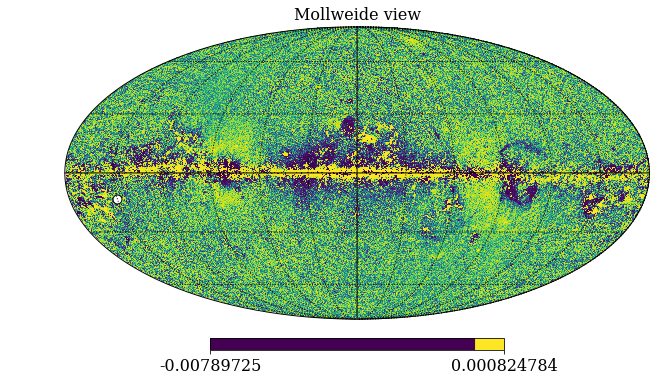

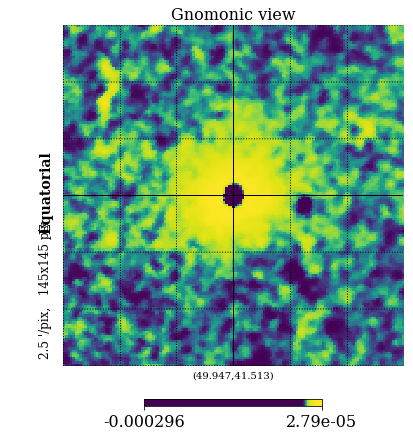

In [5]:
ymap_data, header = map_tools.roi_extract_healpix(ymap_file, cluster.coord.ra.value, cluster.coord.dec.value, 
                                                  cluster.map_reso.to_value('deg'), 
                                                  [cluster.map_fov[0].to_value('deg'), cluster.map_fov[1].to_value('deg')],
                                                  visu=True)
cluster.map_header = header

### Error map and mask

Text(0.5,1,'Source mask')

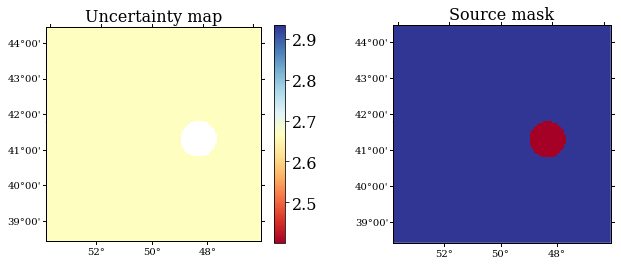

In [6]:
# First guess for the error
ymap_err = ymap_data*0 + np.std(ymap_data)

# Flag signal
for i in [1,2,3,4,5,6]: 
    ymap_err = ymap_data*0 + np.std(ymap_data[np.abs(ymap_data/ymap_err) < 3])
mask = ymap_err*0+1
    
# Mask central source
ramap, decmap = map_tools.get_radec_map(header)
# Central
if mask_source:
    distance = map_tools.greatcircle(ramap, decmap, src1.ra.to_value('deg'), src1.dec.to_value('deg'))
    ymap_err[distance<NFWHMmask*FWHM_planck.to_value('deg')] = np.nan
    mask[distance<NFWHMmask*FWHM_planck.to_value('deg')]     = 0
    
# Secondary
distance = map_tools.greatcircle(ramap, decmap, src2.ra.to_value('deg'), src2.dec.to_value('deg'))
ymap_err[distance<NFWHMmask*FWHM_planck.to_value('deg')] = np.nan
mask[distance<NFWHMmask*FWHM_planck.to_value('deg')]     = 0

# Show the map
fig = plt.figure(0, figsize=(10, 4))
ax = plt.subplot(121, projection=WCS(header))
plt.imshow(1e6*ymap_err, origin='lower', cmap='RdYlBu')
plt.colorbar()
plt.title('Uncertainty map')

ax = plt.subplot(122, projection=WCS(header))
plt.imshow(mask, origin='lower', cmap='RdYlBu')
plt.title('Source mask')

### Zero level

-7.674051198406345e-07


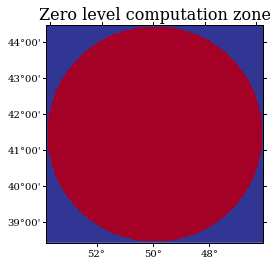

In [7]:
distance = map_tools.greatcircle(ramap, decmap, cluster.coord.ra.to_value('deg'), cluster.coord.dec.to_value('deg'))
wzl = (mask == 1)  * (distance > 3*cluster.theta500.to_value('deg'))
zlmask = distance*0
zlmask[wzl] = 1
ZL = np.mean(ymap_data[wzl])

# Show the map
fig = plt.figure(0, figsize=(10, 4))
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(zlmask, origin='lower', cmap='RdYlBu')
plt.title('Zero level computation zone')

print(ZL)

# Model - data comparison

In [8]:
ymap_model = cluster.get_sz_map(Compton_only=True)
ymap_model = ndimage.gaussian_filter(ymap_model, sigma=FWHM2sigma*(FWHM_planck/map_reso).to_value(''), order=0)

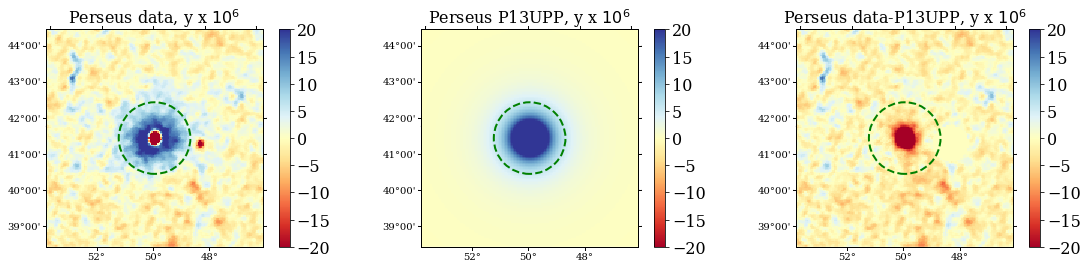

In [9]:
rad = cluster.theta500.to_value('deg')

fig = plt.figure(0, figsize=(18, 4))
ax = plt.subplot(131, projection=WCS(header))
plt.imshow(1e6*ymap_data, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' data, y x $10^6$')
ax = plt.subplot(132, projection=WCS(header))
plt.imshow(1e6*ymap_model, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' P13UPP, y x $10^6$')
ax = plt.subplot(133, projection=WCS(header))
plt.imshow(1e6*(ymap_data-ymap_model)*mask, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' data-P13UPP, y x $10^6$')
plt.savefig(cluster.output_dir+'/ResultsTh_UPP_residual')

### Residual profiles

In [10]:
yprof_rad, yprof_data, yprof_err = map_tools.radial_profile_sb(ymap_data-ZL, 
                                                               (cluster.coord.ra.value, cluster.coord.dec.value), 
                                                               stddev=ymap_err,
                                                               header=header,
                                                               binsize=yprof_reso.to_value('deg'))
yprof_rad, yprof_mod, bid = map_tools.radial_profile_sb(ymap_model, 
                                                        (cluster.coord.ra.value, cluster.coord.dec.value), 
                                                        stddev=ymap_model*0+1,
                                                        header=header,
                                                        binsize=yprof_reso.to_value('deg'))

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/ClusterTools/map_tools.py:575: RuntimeWarning: invalid value encountered in greater
  w_bin_val = (stddev > 0) * (np.isnan(stddev) == False) * (np.isnan(image) == False)


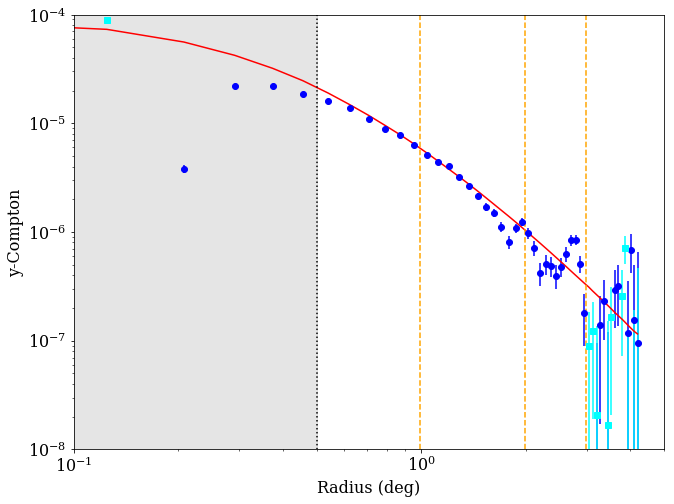

In [11]:
plt.figure(figsize=(10,8))
plt.errorbar(yprof_rad, yprof_data, yprof_err, marker='o', linestyle='', color='blue')
plt.errorbar(yprof_rad, -yprof_data, yprof_err, marker='s', linestyle='', color='cyan')
plt.plot(yprof_rad, yprof_mod, linestyle='-', color='red')
plt.plot([1*cluster.theta500.to_value('deg'),1*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.plot([2*cluster.theta500.to_value('deg'),2*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.plot([3*cluster.theta500.to_value('deg'),3*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.plot([NFWHMmask*FWHM_planck.to_value('deg'),NFWHMmask*FWHM_planck.to_value('deg')], [0,1], linestyle=':', color='k')
plt.fill_between([0,NFWHMmask*FWHM_planck.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.ylim(1e-8, 1e-4)
plt.xlim(1e-1, 5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (deg)')
plt.ylabel('y-Compton')
plt.savefig(cluster.output_dir+'/ResultsTh_compton'+'_mask'+str(mask_source))

In [12]:
print('Uth500: ',cluster.get_thermal_energy_profile(radius=cluster.R500)[1][0])

('Uth500: ', <Quantity 2.61997011e+63 erg>)


In [13]:
20*u.arcmin*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)

<Quantity 436.5577473 kpc>